## Tasks
Assigned to Sierra Stevenson, JSIP intern under Dr. Jonathan Jiang and Dr. Longtao Wu<p>
This analysis is intended to compare observed (MLS/AIRS/GPM_MERGIR) and simulated (UM) data to evaluate<br>how convection is resolved by storm-resolving models.

List of Tasks<p>
[DONE]&nbsp;&nbsp;&nbsp;Task 1 — UM moisture at 100 hPa map<br>
[DONE]&nbsp;&nbsp;&nbsp;Task 2 — MLS moisture at 100 hPa map<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 3 — UM/MLS/AIRS vert. profiles pressure vs temp/moisture<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 4 — UM/MLS PDFs (moisture)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 5 — UM/GPM_MERGIR PDFs (brightness temp)

UM (monthly): Task 1,2
MLS (monthly): Task 1,2

UM (hourly): Task 3-5
MLS (hourly): Task 3-5
AIRS (hourly): 

## Code
Setup

In [3]:
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.stats as sst
import dask
import os
import glob
import below_god as bg
import seaborn as sns

from metpy.interpolate import log_interpolate_1d
from metpy.units import units
from netCDF4 import MFDataset, Dataset, num2date
from pydap.client import open_url

In [41]:
# Conversion factors
hPa_to_Pa = 100
kgkg_to_ppmv = 1.608 * 10 ** 6
VMR_to_ppmv = 10 ** 6

# Monsoon region coordinates (format: [lon1,lon2,lat1,lat2])
# Asian Monsoon
AM_coords = [20, 160,-10,50]
AM_box = [[20,40],[40,140]]

# North American Monsoon
NAM_coords = [-140,-40,-10,50]
NAM_box = [[-10,40],[-140,60]]

AIRS data (yearly)

In [5]:
# Starting with yearly
# TODO: When code is confirmed to work, set to daily and re-run after JPL work hours.

In [6]:
AIRS_file_names = []
AIRS_file1 = '/data/airs/AIRX3STD/v7/2003/AIRS.2003.08.15.L3.RetStd001.v7.0.3.0.G20202222706.hdf'
AIRS_data_yrly = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(AIRS_file1)))

yearly_AIRS = '/data/airs/AIRX3STD/v7/*/AIRS.*.08.15.L3.RetStd001.v7.0.3.0.*.hdf'
# daily_AIRS = '/data/airs/AIRX3STD/v7/*/AIRS.*.08.*.L3.RetStd001.v7.0.3.0.*.hdf'     # TODO: Include up to 09/08

print("Beginning loop. Runtime: 9 sec per file. (2-4 min for yearly data; 70 min for daily data.")

for file in glob.glob(yearly_AIRS):
    print(file)
    AIRS_file_names.append(file)
    AIRS_data_yrly = xr.concat([AIRS_data_yrly, xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(file)))], dim="time")

Beginning loop. Runtime: 9 sec per file. (2-4 min for yearly data; 70 min for daily data.
/data/airs/AIRX3STD/v7/2003/AIRS.2003.08.15.L3.RetStd001.v7.0.3.0.G20202222706.hdf
/data/airs/AIRX3STD/v7/2004/AIRS.2004.08.15.L3.RetStd001.v7.0.3.0.G20195222930.hdf
/data/airs/AIRX3STD/v7/2005/AIRS.2005.08.15.L3.RetStd001.v7.0.3.0.G20194175526.hdf
/data/airs/AIRX3STD/v7/2006/AIRS.2006.08.15.L3.RetStd001.v7.0.3.0.G20193130345.hdf
/data/airs/AIRX3STD/v7/2007/AIRS.2007.08.15.L3.RetStd001.v7.0.3.0.G20192120413.hdf
/data/airs/AIRX3STD/v7/2008/AIRS.2008.08.15.L3.RetStd001.v7.0.3.0.G20191235723.hdf
/data/airs/AIRX3STD/v7/2009/AIRS.2009.08.15.L3.RetStd001.v7.0.3.0.G20191120349.hdf
/data/airs/AIRX3STD/v7/2010/AIRS.2010.08.15.L3.RetStd001.v7.0.3.0.G20185230916.hdf
/data/airs/AIRX3STD/v7/2011/AIRS.2011.08.15.L3.RetStd001.v7.0.3.0.G20184153420.hdf
/data/airs/AIRX3STD/v7/2012/AIRS.2012.08.15.L3.RetStd001.v7.0.3.0.G20183101552.hdf
/data/airs/AIRX3STD/v7/2013/AIRS.2013.08.15.L3.RetStd001.v7.0.3.0.G20181235357.h

KeyboardInterrupt: 

In [ ]:
AIRS_data = AIRS_data_yrly
AIRS_prs = AIRS_data['StdPressureLev:ascending']

In [ ]:
AIRS_data = AIRS_data_yrly.mean(dim='time')

# Global Average 
# Average ascending/descending temperature
AIRS_t_A = AIRS_data['Temperature_A'].mean(dim=['YDim:ascending', 'XDim:ascending', ])                              # Ascending orbit temperature
AIRS_t_D = AIRS_data['Temperature_D'].mean(dim=['YDim:descending', 'XDim:descending'])                              # Descending orbit temperature
AIRS_t = (AIRS_t_A.values + AIRS_t_D.values) / 2                                                                    # Average temperature
AIRS_t_prs = (AIRS_t_A['StdPressureLev:ascending'].values + AIRS_t_D['StdPressureLev:descending'].values) / 2       # Temperature-associated pressure

# Average ascending/descending moisture
AIRS_h2o_A = AIRS_data['H2O_MMR_A'].mean(dim=['YDim:ascending', 'XDim:ascending'])                                  # Ascending orbit moisture
AIRS_h2o_D = AIRS_data['H2O_MMR_D'].mean(dim=['YDim:descending', 'XDim:descending'])                                # Descending orbit moisture
AIRS_h2o = ((AIRS_h2o_A.values + AIRS_h2o_D.values) / 2) * kgkg_to_ppmv                                             # Average moisture
AIRS_h2o_prs = (AIRS_h2o_A['H2OPressureLev:ascending'].values + AIRS_h2o_D['H2OPressureLev:descending'].values) / 2 # Moisture-associated pressure
AIRS_h2o_prs = AIRS_h2o_prs

AIRS/MLS: Pressure vs. moisture/temperature

In [ ]:
# # Find MLS data where pressure < 300 hPa
# MLS_prs_idxs_under300 = np.where(MLS_prs * hPa_to_Pa <= (300 + 50), np.arange(len(MLS_prs)), np.nan)       # Get list of indexes where MLS pressure < 300 hPa
# MLS_prs_idxs_under300 = MLS_prs_idxs_under300[~np.isnan(MLS_prs_idxs_under300)].astype(int)                # Remove NaNs and convert values to integers in list
# MLS_h2o_under300 = MLS_h2o.mean(dim=['Lat','Lon'])[MLS_prs_idxs_under300]                                  # Get corresponding moisture values

# # Find AIRS data where pressure >= 300 hPa
# AIRS_prs_idxs_over300 = np.where(AIRS_h2o_prs >= 300, np.arange(len(AIRS_h2o_prs)), np.nan)               # Get list of indexes where AIRS pressure >= 300 hPa
# AIRS_prs_idxs_over300 = AIRS_prs_idxs_over300[~np.isnan(AIRS_prs_idxs_over300)].astype(int)             # Remove NaNs and convert values to integers in list
# AIRS_h2o_over300 = AIRS_h2o[AIRS_prs_idxs_over300]   

UM Data

In [10]:
# Folder containing data
path = '/nas/bigdata_static/longtaow/'

# Read in UM data
UM_data_hus = xr.open_mfdataset(path+'DYAMOND/Monsoon/hus/*.nc', parallel=True)     # Moisture (kg/kg)
UM_data_prs = xr.open_mfdataset(path+'DYAMOND/Monsoon/pfull/*.nc', parallel=True)   # Pressure (Pa)
UM_data_ta = xr.open_mfdataset(path+'DYAMOND/Monsoon/ta/*.nc', parallel=True)       # Temperature (C)

print("UM data read.")

# Temporal average
UM_avg_prs = UM_data_prs.mean(dim='time')     # Pressure
UM_avg_hus = UM_data_hus.mean(dim='time')     # Moisture
UM_avg_ta = UM_data_ta.mean(dim='time')     # Temperature


# Model level number start/end indexes enclosing 100 hPa
lv1, lv2 = 45, 55

# Isolate pressure data variable
UM_prs = UM_avg_prs['air_pressure'][:,lv1:lv2]

# Isolate moisture data and convert units from kg/kg to ppmv
UM_hus = UM_avg_hus['specific_humidity'][:,lv1:lv2] * kgkg_to_ppmv

# Isolate temperature and convert units from K to °C
UM_ta = UM_avg_ta['air_temperature']

UM data read.


In [48]:
# Function that takes an average across a geographic range for an Xarray DataArray
def GeogAvg(xarr, range="global"):
    if range == "global":
        return xarr.mean(dim=['latitude','longitude'])
    elif range == "AM":
        return xarr.sel(latitude=slice(AM_coords[2],AM_coords[3])).sel(longitude=slice(AM_coords[0],AM_coords[1])).mean(dim=['latitude','longitude'])
    elif range == "NAM":
        return xarr.sel(latitude=slice(NAM_coords[2],NAM_coords[3])).sel(longitude=slice(NAM_coords[0],NAM_coords[1])).mean(dim=['latitude','longitude'])
    else:
        print("Not implemented, range must be set to 'global', 'AM', or 'NAM'.")

UM: Geographic Averages

In [ ]:
UM_ta_NAM

In [52]:
# # Global
# UM_prs_globalavg = GeogAvg(UM_prs, "global")
# UM_hus_globalavg = GeogAvg(UM_hus, "global")
# UM_ta_globalavg = GeogAvg(UM_ta, "global")

# # AM
# UM_prs_AM = GeogAvg(UM_prs, "AM")
# UM_hus_AM = GeogAvg(UM_hus, "AM")
# UM_ta_AM = GeogAvg(UM_ta, "AM")

# # NAM
# UM_prs_NAM = GeogAvg(UM_prs, "NAM")
# UM_hus_NAM = GeogAvg(UM_hus, "NAM")
# UM_ta_NAM = GeogAvg(UM_ta, "NAM")

UM_ta_NAM = UM_ta.mean(dim=['latitude','longitude'])
UM_ta_NAM.values()

: 

: 

## Figures

Define coordinates for monsoon regions

Labels for plotting

In [ ]:
# All
date_range = "08/11/2016 — 09/08/2016"

# UM
UM_name = "Unified Model"

# MLS
MLS_dates = "08/2004 — 08/2022"
MLS_name = "MLS"

# GPM_MERGIR
GPM_name = "GPM_MERGIR Data

Functions for figure creation

In [33]:
def CreateVertProfile(arr, arr_prs, arr2=0, arr2_prs=None, data_label="Moisture", source="AIRS", source2="MLS", date_range=date_range, custom_units=None, full_AIRS=None, layer="all"):
    if data_label == "Moisture":
        units = "ppmv"
        color = "darkblue"
    elif data_label == "Temperature":
        units = "°C"
        color = "darkred"
    else:
        units = custom_units

        
    if "layer" == "UTLS":
        plt.ylim(50,300)
        layer_label=", Upper Troposphere/Lower Atmosphere only"
    else:
        layer_label=""


    plt.title(f"{source} Data: Vertical Profile of {data_label} ({units})\nfor {date_range} {layer_label}")
    plt.ylabel("Pressure (hPa)")
    plt.xlabel(f"{data_label} ({units})")
    plt.gca().invert_yaxis()

    plt.plot(arr, arr_prs, label=source, color=color)

    if np.array(arr2).any() == True:
        plt.plot(arr2, arr2_prs, label=source2, color="gray")
        plt.legend()
    if full_AIRS == True:
        plt.plot(AIRS_h2o, AIRS_h2o_prs, label="AIRS (full)", zorder=-1, alpha=1, linewidth=2, linestyle="--", color="darkblue")
    plt.show()

Task 3: Vertical profiles of pressure vs. temperature/moisture (UM, MLS)

Global average, all atmospheric layers

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

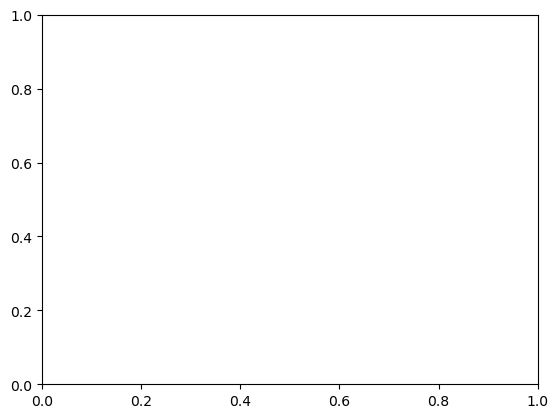

In [35]:
plt.plot(UM_hus_globalavg, UM_prs_globalavg)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

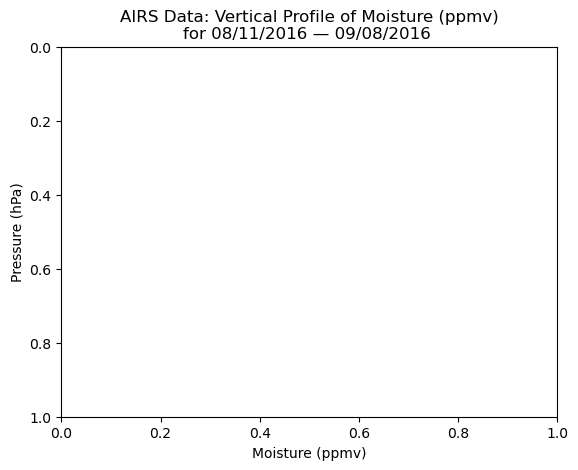

In [34]:
# Global average
# Pressure vs. Moisture (MLS/AIRS)
# CreateVertProfile(AIRS_h2o, AIRS_h2o_prs, UM_hus, UM_prs)   # TODO: Add MLS data
CreateVertProfile(UM_hus_globalavg, UM_prs_globalavg)

# Pressure vs. Temperature  (AIRS)
# CreateVertProfile(AIRS_t-273.15, AIRS_t_prs, data_label="Temperature")
# CreateVertProfile(UM_t, UM_t_prs, data_label="Temperature")

Global average, UT/LS

Asian Monsoon, all atmospheric layers

Asian Monsoon, UT/LS

North American Monsoon, all atmospheric layers

North American Monsoon, UT/LS